In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-whitegrid')

In [4]:
train = pd.read_csv('inputs/Train.csv')
test = pd.read_csv('inputs/Test.csv')

In [5]:
train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


### Mathematical transformations for skewed features.

<AxesSubplot:xlabel='target', ylabel='Density'>

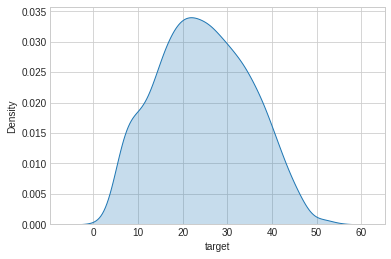

In [14]:
sns.kdeplot(train.target, shade = True)

<AxesSubplot:xlabel='target', ylabel='Density'>

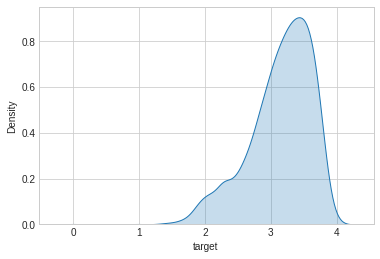

In [46]:
sns.kdeplot(train.target.apply(np.log1p), shade = True)

<AxesSubplot:xlabel='target', ylabel='Density'>

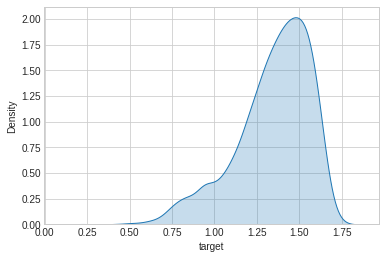

In [47]:
sns.kdeplot(train.target.apply(np.log10), shade = True)

<AxesSubplot:xlabel='target', ylabel='Density'>

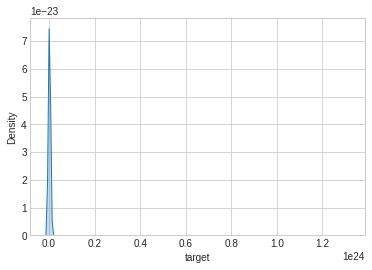

In [48]:
sns.kdeplot(train.target.apply(np.expm1), shade = True)

In [50]:
cat_cols = [cols for cols in train.columns if train[cols].dtype == 'object']
cat_cols

['ward', 'ADM4_PCODE']

In [51]:
train[cat_cols]

,ward,ADM4_PCODE
0,41601001: Ward 1,ZA4161001
1,41601002: Ward 2,ZA4161002
2,41601003: Ward 3,ZA4161003
3,41601004: Ward 4,ZA4161004
4,41601005: Ward 5,ZA4161005
...,...,...
2817,34503001: Ward 1,ZA3453001
2818,34503002: Ward 2,ZA3453002
2819,34503003: Ward 3,ZA3453003
2820,34503004: Ward 4,ZA3453004


In [57]:
train[['ward_number', 'ward_category']] = (
    train['ward'].str.split(':', expand = True))

train[['ward', 'ward_number', 'ward_category']]

,ward,ward_number,ward_category
0,41601001: Ward 1,41601001,Ward 1
1,41601002: Ward 2,41601002,Ward 2
2,41601003: Ward 3,41601003,Ward 3
3,41601004: Ward 4,41601004,Ward 4
4,41601005: Ward 5,41601005,Ward 5
...,...,...,...
2817,34503001: Ward 1,34503001,Ward 1
2818,34503002: Ward 2,34503002,Ward 2
2819,34503003: Ward 3,34503003,Ward 3
2820,34503004: Ward 4,34503004,Ward 4


In [59]:
train[['ward', 'ward_number', 'ward_category']].describe()

,ward,ward_number,ward_category
count,2822,2822,2822
unique,2822,2822,130
top,41601001: Ward 1,41601001,Ward 1
freq,1,1,144


In [ ]:
train.split()

In [63]:
def create_code_category(data_frame):
    data_frame['CodeCategory'] = data_frame['ADM4_PCODE'].str.split('', expand = False)
    return data_frame

In [64]:
train = create_code_category(train)
train

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,ward_number,ward_category,CodeCategory
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039,41601001,Ward 1,"[, Z, A, 4, 1, 6, 1, 0, 0, 1, ]"
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775,41601002,Ward 2,"[, Z, A, 4, 1, 6, 1, 0, 0, 2, ]"
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000,41601003,Ward 3,"[, Z, A, 4, 1, 6, 1, 0, 0, 3, ]"
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778,41601004,Ward 4,"[, Z, A, 4, 1, 6, 1, 0, 0, 4, ]"
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000,41601005,Ward 5,"[, Z, A, 4, 1, 6, 1, 0, 0, 5, ]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,34503001: Ward 1,3261.68067,11551.56486,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,...,0.006203,0,0,ZA3453001,-27.675590,23.057920,9.118927,34503001,Ward 1,"[, Z, A, 3, 4, 5, 3, 0, 0, 1, ]"
2818,34503002: Ward 2,1463.06432,7908.90411,15.668000,0.636235,0.002262,0.010433,0.000000,0.003030,0.000000,...,0.008414,0,0,ZA3453002,-27.591408,22.907161,1.697395,34503002,Ward 2,"[, Z, A, 3, 4, 5, 3, 0, 0, 2, ]"
2819,34503003: Ward 3,1395.18881,6242.37527,13.238795,0.855975,0.006601,0.061118,0.000812,0.003912,0.000812,...,0.003670,0,0,ZA3453003,-27.952550,22.749698,2.792501,34503003,Ward 3,"[, Z, A, 3, 4, 5, 3, 0, 0, 3, ]"
2820,34503004: Ward 4,1679.66964,8014.73089,17.639523,0.792552,0.004423,0.016099,0.000000,0.000674,0.000000,...,0.004803,0,0,ZA3453004,-27.913875,22.755314,2.793699,34503004,Ward 4,"[, Z, A, 3, 4, 5, 3, 0, 0, 4, ]"


In [ ]:
enocder = OrdinalEncoder(handle_unknown = 'error')
train[cat_cols

In [ ]:
#Group transformations.
#e.g; 

In [ ]:
#  dataset['Ward_Category'] = dataset['ward'].str.replace(PATTERN, '', regex = True)
    
# /////////////////////////////////////
#     def create_code_category(data_frame):
#     data_frame['Code_Category'] = data_frame['ADM4_PCODE'].str[:3]
#     data_frame['Code_Category'] = data_frame['Code_Category'].map({
#         'ZA5' : 'ZA5', 'ZA7' : 'ZA7', 'ZA9' : 'ZA9',
#         'ZA6' : 'ZA6', 'ZA8' : 'ZA8', 'ZA4' : 'ZA4',
#         'ZA3' : 'ZA3', 'ZA2' : 'ZA2', 'ZA1' : 'ZA1'})
#     return data_frame

# copy_train = create_code_category(copy_train)
# copy_test = create_code_category(copy_test)

# //////////////////////////////////
# #Ratio of individuals and households.
